# Multiarmed bandit

## Reinforcement Learning interface

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class Environment():
    def actions(self):
        raise NotImplementedError('Inheriting classes must override actions.')

    def step(self):
        raise NotImplementedError('Inheriting classes must override step')
class Agent():
    def __init__(self, num_actions):
        self.num_actions=num_actions
    def act(self):
        raise NotImplementedError
    def update(self):
        raise NotImplementedError  

# Bandit environment

In [2]:
class BanditEnv():

    def __init__(self, choices):
        """ here choices is a list of distributions """
        """ each element is a tuple (name,(parameters)) """
        """ avaliable distributions: """
        """ exponential - parameter is lambda """
        """ poisson - parameter is lambda """
        """ uniform - parameters are interval limits """
        self.num_actions=len(choices)
        self.choices=choices

    def step(self, action):
        dist=self.choices[action][0]
        parameters=self.choices[action][1]

        if dist=="exponential":
            return np.random.exponential(parameters)
        if dist=="poisson":
            return np.random.poisson(parameters)
        if dist=="uniform":
            return np.random.uniform(parameters[0],parameters[1])
        if dist=="normal":
            return np.random.normal(parameters[0],parameters[1])

    def get_optimal_average(self):
        max_average=-float('inf')

        for dist,parameters in self.choices:
            if dist=="exponential":
                average=parameters
            if dist=="poisson":
                average=parameters
            if dist=="uniform":
                average=(parameters[0]+parameters[1])/2
            if dist=="normal":
                average=parameters[0]

            if average>max_average:
                max_average=average

        return max_average


# Plotting data

In [3]:
def get_averages(Agent):
    net=0
    averages=[]

    for i in range(len(Agent.rewards)):
        net+=Agent.rewards[i]
        averages.append(net/(i+1))

    return averages
def get_regret(Agent,optimal_average):
    net=0
    regrets=[]

    for i in range(len(Agent.rewards)):
        net+=Agent.rewards[i]
        regrets.append(optimal_average*(i+1)-net)

    return regrets

# Random agent 

In [4]:
class RandomAgent(Agent):
    def __init__(self,num_actions):
        super(RandomAgent,self).__init__(num_actions)
        self.rewards=[]
    def act(self):
        return np.random.randint(0,self.num_actions)
    def update(self, reward):
        self.rewards.append(reward)

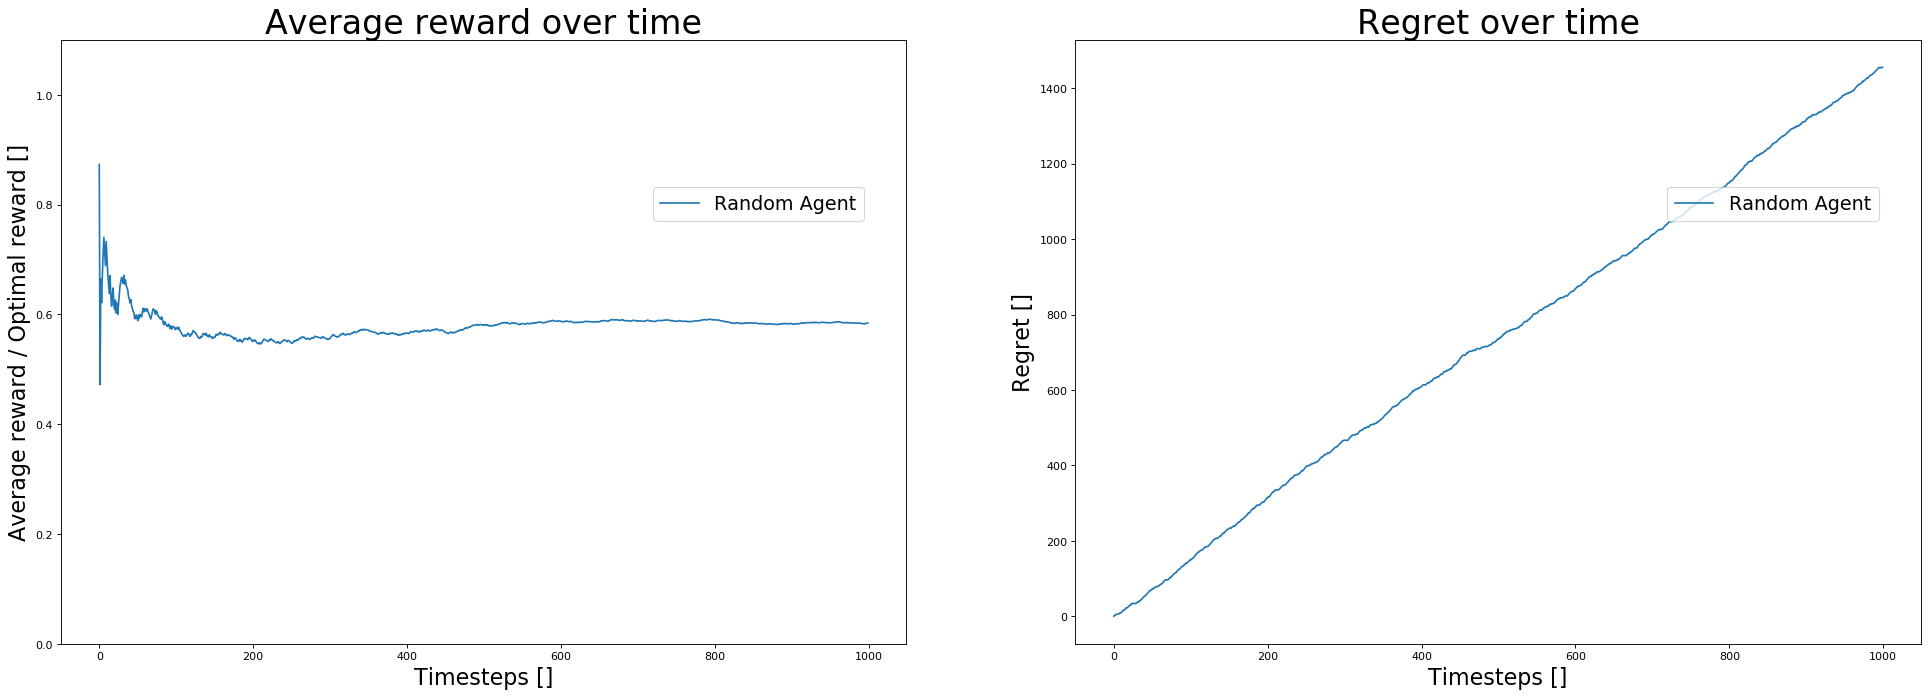

In [5]:
from jupyterCode import RandomAgentPlot
RandomAgentPlot()

# ε-Greedy approach

In [6]:
class EpsilonGreedyAgent(Agent):

    def __init__(self, num_actions, epsilon=0.01):
        super(EpsilonGreedyAgent, self).__init__(num_actions)
        self.rewards=[]
        self.averages=[0]*num_actions
        self.frequencies=[0]*num_actions
        self.epsilon=epsilon
    def act(self):
        if np.random.rand()>self.epsilon:
            self.last_action=np.argmax(self.averages)
        else:
            self.last_action=np.random.choice(range(self.num_actions))

        self.frequencies[self.last_action]+=1
        return self.last_action
    def update(self, reward):
        self.rewards.append(reward)
        """ maintaining the average according to the: """
        """ Q_{n+1}=\frac{n*Q_n+q_{n+1}}{n+1} """
        self.averages[self.last_action]=((self.frequencies[self.last_action]-1)*self.averages[self.last_action]+reward) \
                                                                               /self.frequencies[self.last_action]

# Optimistic greedy

In [7]:
class OptimisticAgent(Agent):

    def __init__(self, num_actions, optimistic_average=10):
        super(OptimisticAgent, self).__init__(num_actions)
        self.rewards=[]
        self.averages=[optimistic_average]*num_actions
        self.frequencies=[0]*num_actions

    def act(self):
        self.last_action=np.argmax(self.averages)
        self.frequencies[self.last_action]+=1
        return self.last_action
    def update(self, reward):
        self.rewards.append(reward)
        """ maintaining the average according to the: """
        """ Q_{n+1}=\frac{n*Q_n+q_{n+1}}{n+1} """
        self.averages[self.last_action]=((self.frequencies[self.last_action]-1)*self.averages[self.last_action]+reward) \
                                                                               /self.frequencies[self.last_action]

## Over 1000 timesteps

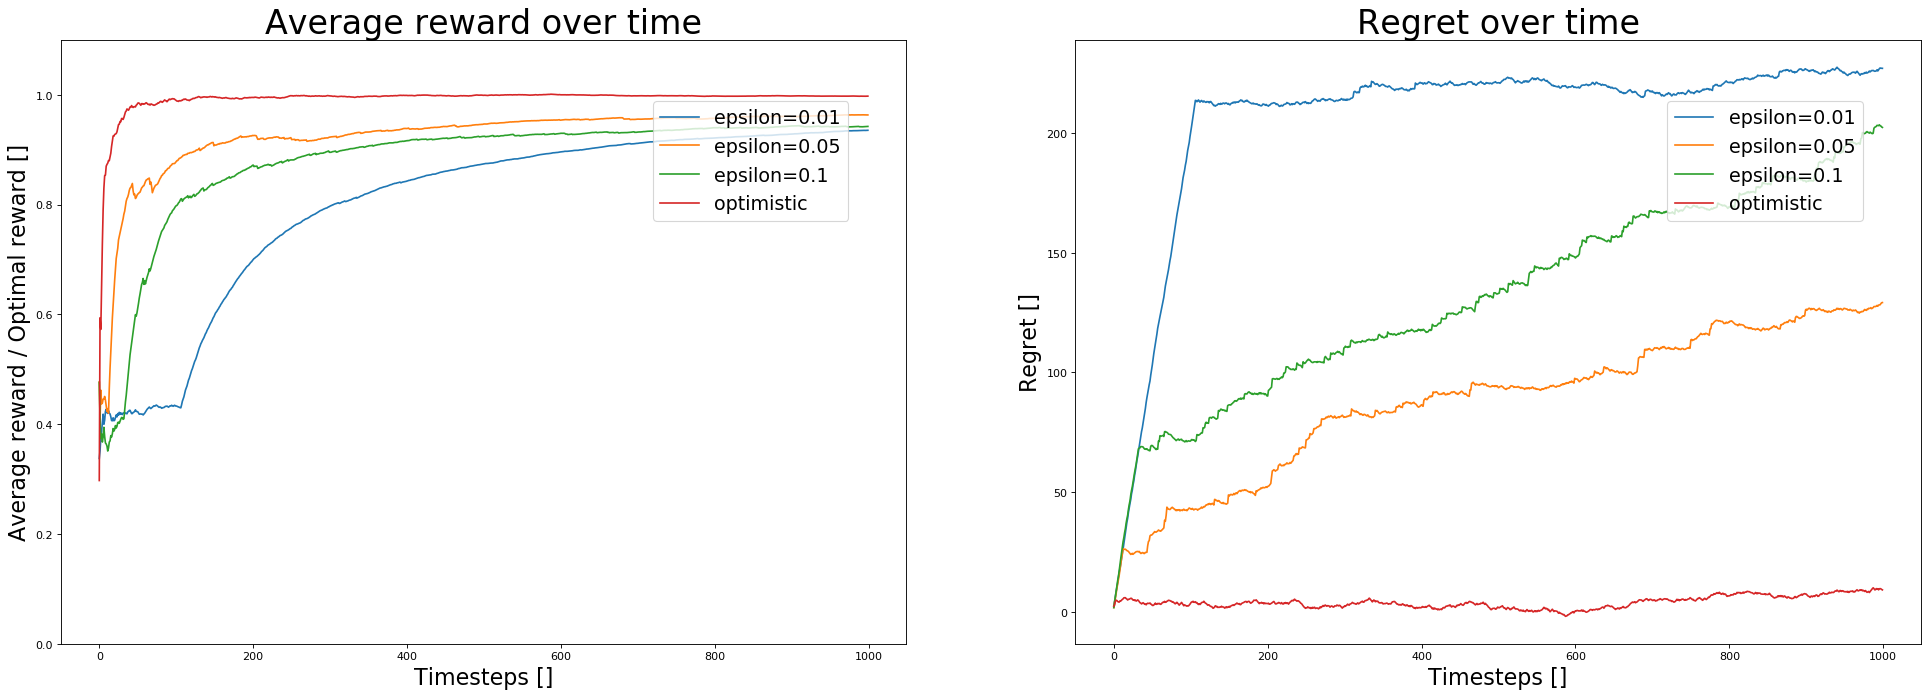

In [10]:
from jupyterCode import GreedyPlot
GreedyPlot(1000)

## Over 10000 timesteps

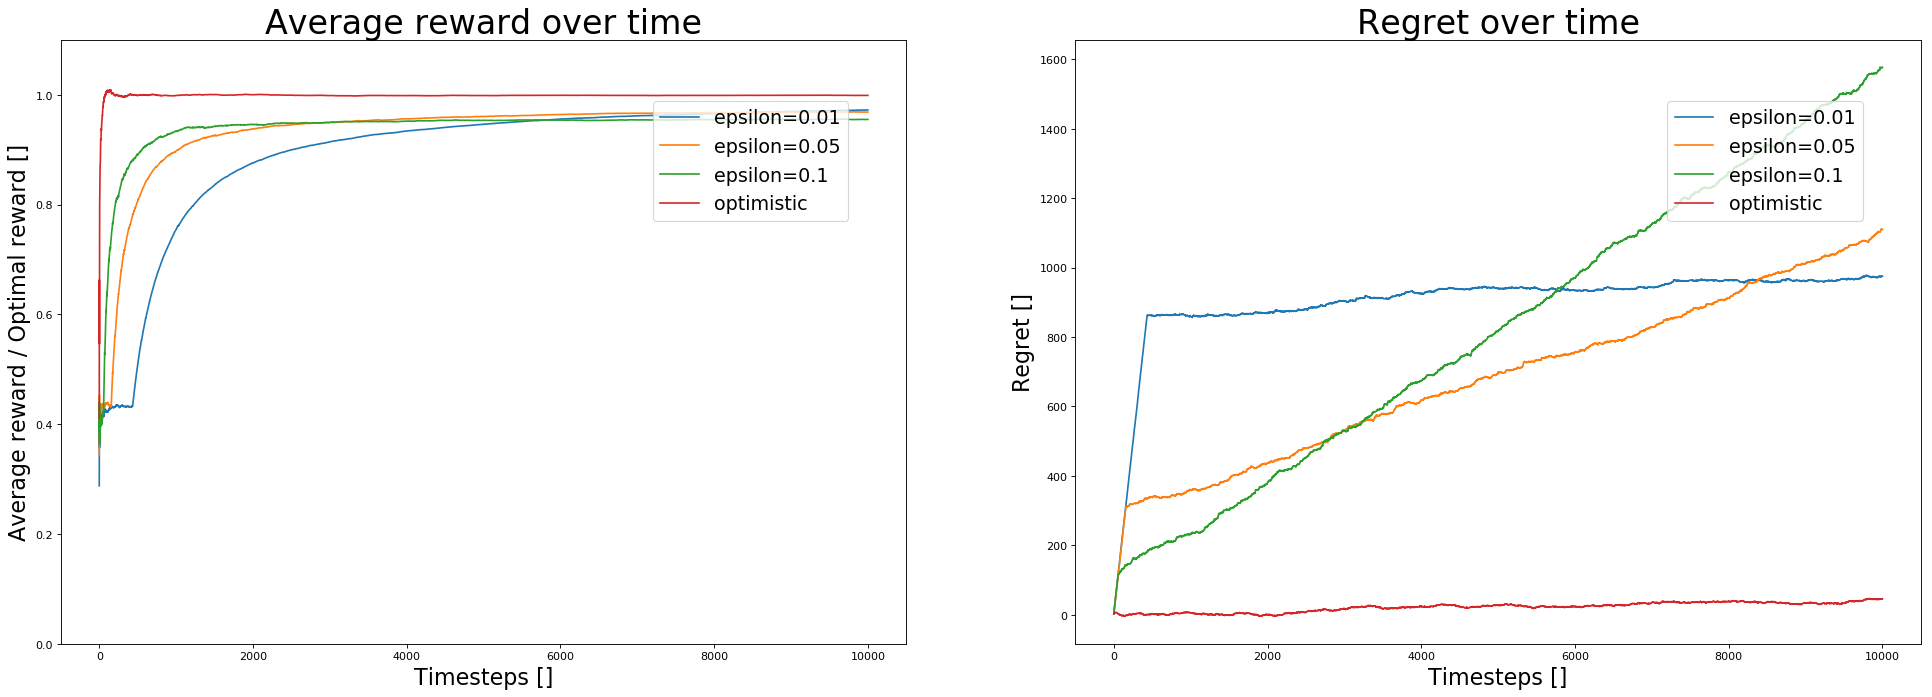

In [11]:
GreedyPlot(10000)

# Upper Confidence Bound

In [12]:
class UCBAgent(Agent):

    def __init__(self, num_actions, c=2):
        super(UCBAgent, self).__init__(num_actions)
        self.rewards=[]
        self.averages=[0]*num_actions
        self.frequencies=[0]*num_actions
        self.c=c

    def act(self):
        """UPPER CONFIDENCE BOUND """
        """this algorithm selects the action that has the maximum value of the function"""
        """average+c*sqrt(ln(t)/frequency)"""

        max_confidence=-float('inf')
        self.last_action=0

        for action in range(len(self.averages)):
            current_confidence=self.averages[action]+ \
                               self.c*np.sqrt(np.log(len(self.rewards)+1)/(self.frequencies[action]+1))
            if current_confidence > max_confidence:
                max_confidence=current_confidence
                self.last_action=action

        self.frequencies[self.last_action]+=1

        return self.last_action
    def update(self, reward):
        self.rewards.append(reward)
        """ maintaining the average according to the: """
        """ Q_{n+1}=\frac{n*Q_n+q_{n+1}}{n+1} """
        self.averages[self.last_action]=((self.frequencies[self.last_action]-1)*self.averages[self.last_action]+reward) \
                                                                               /self.frequencies[self.last_action]

# Gradient Agent

In [13]:
class GradientAgent(Agent):

    def __init__(self, num_actions, alpha=0.1):
        super(GradientAgent, self).__init__(num_actions)
        self.rewards=[]
        self.preferences=[0]*num_actions
        self.alpha=alpha
        self.num_actions=num_actions

    def act(self):
        probabilities=np.exp(self.preferences)
        probabilities/=np.sum(probabilities)
        self.last_action=np.random.choice(np.arange(self.num_actions),p=probabilities)
        return self.last_action

    def update(self, reward):
        self.rewards.append(reward)
        average_reward=np.mean(self.rewards)

        probabilities=np.exp(self.preferences)
        probabilities/=np.sum(probabilities)

        for i in range(len(self.preferences)):
            if i==self.last_action:
                self.preferences[i]+=self.alpha*(reward-average_reward)*(1-probabilities[i])
            else:
                self.preferences[i]-=self.alpha*(reward-average_reward)*probabilities[i]

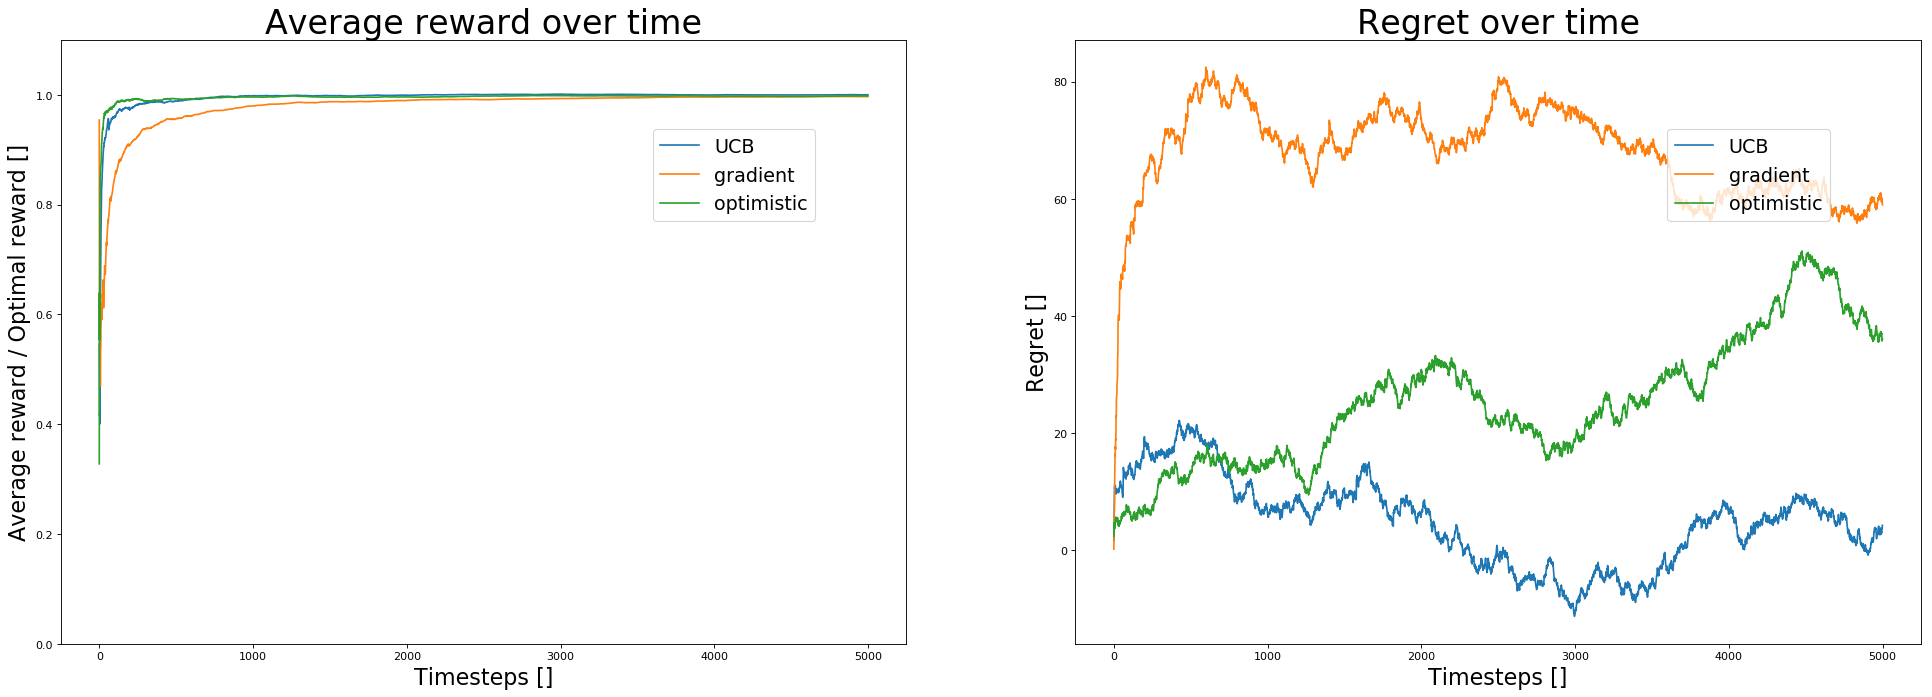

In [14]:
from jupyterCode import UCBGradientPlot
UCBGradientPlot(5000)